# MultiClass Classification with Sklearn

In [6]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd


from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

'''import helpers'''
import tools as tools

In [9]:
#load dependencies 
import pandas as pd
import numpy as np
import transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
#from datasets import Dataset
from transformers import TrainingArguments
from transformers import Trainer

from argparse import ArgumentParser
from sklearn.metrics import mean_absolute_error, accuracy_score
import torch 
from torch import cuda, true_divide
#from accelerate import Accelerator

from datasets import load_metric

#accelerator = Accelerator()
#device = accelerator.device

from pathlib import Path

from huggingface_hub import HfApi
from huggingface_hub.commands.user import login

api = HfApi()
login(token = Path('../data/huggingface_api_key.txt').read_text())

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/jonas/.cache/huggingface/token
Login successful


In [10]:
'''import processed data'''
df = pd.read_csv(os.path.abspath(os.path.join('..', 'data/processed/'))+'/data_processed.csv')

In [11]:
df.head(5)

,doi,text_id,text,sdg,labels_negative,labels_positive,agreement,text_clean
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"""From a gender perspective, Paulgaard points o...",5,1,8,0.777778,from a gender perspective paulgaard points out...
1,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,8,0.777778,the average figure also masks large difference...
2,10.1787/9789264117563-8-en,000bfb17e9f3a00d4515ab59c5c487e7,The Israel Oceanographic and Limnological Rese...,6,0,3,1.000000,the israel oceanographic and limnological rese...
3,10.18356/805b1ae4-en,001180f5dd9a821e651ed51e30d0cf8c,Previous chapters have discussed ways to make ...,2,0,3,1.000000,previous chapters have discussed ways to make ...
4,10.1017/S0008423907070424,00162fc8346ca9cd525d8f87ac2b5352,The “War on Terror” and the Framework of Inter...,16,0,7,1.000000,the war on terror and the framework of interna...


In [25]:
'''split test train'''
X_train, X_test, y_train, y_test = train_test_split(df['text_clean'],
                                                    df['sdg'].values,
                                                    test_size = .3,
                                                    stratify=df['sdg'].values,
                                                    random_state = 1,
                                                    shuffle = True)
print('train size:', len(X_train))
print('test size:', len(X_test))

assert len(set(y_train)) == len(set(y_test)), "Unequal splits with some labels missing"

train size: 13653
test size: 5852


In [26]:
'''extract features using tfidf vecorization:'''
vectorizer = TfidfVectorizer(ngram_range = (1,3),min_df = 0.01, max_df = 0.95)
vect = vectorizer.fit(X_train)
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)

/Users/jonas/opt/anaconda3/envs/gis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy: 90.0 %
Test accuracy: 84.0 %


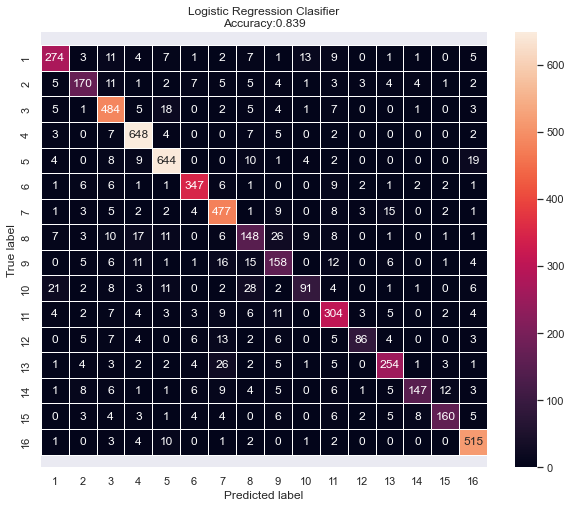

In [27]:
clf = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial').fit(X_train, y_train)
print('Training accuracy:', clf.score(X_train, y_train).round(2)*100, "%")
print('Test accuracy:', clf.score(X_test, y_test).round(2)*100, "%")
y_hat = clf.predict(X_test)
tools.show_labels(y_test, y_hat, title = 'Logistic Regression Clasifier', class_range = (1,17))

In [28]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           1       0.84      0.81      0.82       339
           2       0.79      0.75      0.77       228
           3       0.83      0.90      0.86       536
           4       0.90      0.96      0.93       678
           5       0.90      0.92      0.91       701
           6       0.91      0.90      0.90       386
           7       0.83      0.89      0.86       533
           8       0.61      0.60      0.60       248
           9       0.65      0.67      0.66       236
          10       0.75      0.51      0.60       180
          11       0.78      0.83      0.80       367
          12       0.86      0.61      0.71       141
          13       0.84      0.81      0.82       314
          14       0.89      0.68      0.77       215
          15       0.87      0.76      0.81       211
          16       0.90      0.96      0.92       539

    accuracy                           0.84      5852
   macro avg       0.82   

In [29]:
'''check highest predictors to see if model learnt to make sense out of SDGs'''
df_lambda = tools.get_topwords(clf, vectorizer, n = 10, n_models = 16, show_idxmax = True)
print(f'Shape:{df_lambda.shape}')
display(df_lambda)

/Users/jonas/opt/anaconda3/envs/gis/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


sdg_1            poverty
sdg_2               food
sdg_3             health
sdg_4          education
sdg_5              women
sdg_6              water
sdg_7             energy
sdg_8         employment
sdg_9     infrastructure
sdg_10        inequality
sdg_11             urban
sdg_12             waste
sdg_13           climate
sdg_14         fisheries
sdg_15      biodiversity
sdg_16               law
dtype: object

Shape:(16, 1)


,Keywords
sdg_1,"[(poverty, 11.453), (poor, 6.149), (children, ..."
sdg_2,"[(food, 9.203), (agricultural, 6.984), (farmer..."
sdg_3,"[(health, 10.144), (care, 6.527), (patients, 5..."
sdg_4,"[(education, 9.641), (students, 8.628), (schoo..."
sdg_5,"[(women, 13.079), (gender, 10.234), (female, 5..."
sdg_6,"[(water, 13.349), (groundwater, 5.746), (river..."
sdg_7,"[(energy, 10.756), (electricity, 8.347), (powe..."
sdg_8,"[(employment, 5.447), (labour, 5.101), (worker..."
sdg_9,"[(infrastructure, 5.713), (innovation, 5.278),..."
sdg_10,"[(inequality, 8.484), (income, 4.57), (social,..."


In [12]:
from datasets import load_metric
import numpy as np


def compute_metrics_fn(eval_preds):
  metrics = dict()
  
  accuracy_metric = load_metric('accuracy')
  precision_metric = load_metric('precision')
  recall_metric = load_metric('recall')
  f1_metric = load_metric('f1')


  logits = eval_preds.predictions
  labels = eval_preds.label_ids
  preds = np.argmax(logits, axis=-1)  
  
  metrics.update(accuracy_metric.compute(predictions=preds, references=labels))
  metrics.update(precision_metric.compute(predictions=preds, references=labels, average='weighted'))
  metrics.update(recall_metric.compute(predictions=preds, references=labels, average='weighted'))
  metrics.update(f1_metric.compute(predictions=preds, references=labels, average='weighted'))


  return metrics


In [2]:
import wandb
from pathlib import Path
wandb_api_key = Path('../data/wandb_api_key.txt').read_text()

wandb.login(key=wandb_api_key)

wandb: Currently logged in as: jonas-nothnagel. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/jonas/.netrc


True

In [3]:
sweep_config = {
    'method': 'random'
}

# hyperparameters
parameters_dict = {
    'epochs': {
        'value': 1
        },
    'batch_size': {
        'values': [8, 16, 32, 64]
        },
    'learning_rate': {
        'distribution': 'log_uniform_values',
        'min': 1e-5,
        'max': 1e-3
    },
    'weight_decay': {
        'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    },
}


sweep_config['parameters'] = parameters_dict
sweep_id = wandb.sweep(sweep_config, project='sdg-classifier-roberta-base')

Create sweep with ID: nptl26ml
Sweep URL: https://wandb.ai/jonas-nothnagel/sdg-classifier-roberta-base/sweeps/nptl26ml


In [10]:
sweep_config

{'method': 'random',
 'parameters': {'epochs': {'value': 1},
  'batch_size': {'values': [8, 16, 32, 64]},
  'learning_rate': {'distribution': 'log_uniform_values',
   'min': 1e-05,
   'max': 0.001},
  'weight_decay': {'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]}}}

In [67]:

import pandas as pd
import numpy as np
import transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import Dataset
from transformers import TrainingArguments
from transformers import Trainer 

from argparse import ArgumentParser
from sklearn.metrics import mean_absolute_error, accuracy_score
import torch 
from torch import cuda, true_divide

from datasets import load_metric



In [5]:
# make labels
def make_labels():

    labels = df_osdg['target'].unique()
    labels.sort()
    num_labels = len(labels)
    id2label = {idx:label for idx, label in enumerate(labels)}
    label2id = {label:idx for idx, label in enumerate(labels)}

    return labels, num_labels, id2label, label2id

# set-up tokenizer
def tokenize_function(examples):

    return tokenizer(examples["text_clean"],  truncation=True, padding=True)

In [6]:
# map labels
def map_labels(example):
    # Shift labels to start from 0
    label_id = label2id[example["target"]]
    return {"labels": label_id, "label_name": id2label[label_id]}


In [68]:
df_osdg = pd.read_csv("../data/processed/data_transformer.csv")
df_osdg['target'] = df_osdg['target'].astype(str)
dataset =  Dataset.from_pandas(df_osdg)


In [69]:
dataset

Dataset({
    features: ['text_clean', 'target'],
    num_rows: 18033
})

In [70]:
dataset = dataset.train_test_split(test_size=0.2)

In [10]:
# make labels
labels, num_labels, id2label, label2id = make_labels()
dataset = dataset.map(map_labels)

  0%|          | 0/18033 [00:00<?, ?ex/s]

In [11]:
dataset

Dataset({
    features: ['text_clean', 'target', 'labels', 'label_name'],
    num_rows: 18033
})